In [0]:
#@markdown #SpeechToEmotion-keras
#@markdown ---
#@markdown using a 4 Layer 2DCNN to predict the 
#@markdown emotions out of Log-Mel-Spectrum features

In [0]:
#@markdown connect the google drive to colab notebook
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
#@title Imports
#@markdown import all important dependencies

%matplotlib inline
%reload_ext autoreload
%autoreload 2

import json
import random
import numpy as np
import matplotlib.pyplot as plt

# Keras
import keras
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Conv2D,BatchNormalization, MaxPooling2D, Dense, Activation, Reshape, Dropout
from keras.layers import Dense, Conv2D, Flatten
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras import optimizers
from keras.models import load_model

In [0]:
model_config = {
    'cnn' : {
        'batch_size' : 64,
        'num_classes' : 4,
        'num_epochs' : 300,
        'padding_mode' : 'constant', # same, constant
        'padding_size' : 300,
        'learning_rate_min' : 0.000001,
        'learning_rate_max' : 0.001,
        'model_name': 'Audio_300_26_2DCNN_4L(64_32_32_32)_300.h5'
    }
}

config = model_config['cnn']





In [0]:
#@title Dataloader
#@markdown create a dataloader do import the input data and export the predictions

class KerasDataloader():
    """
    Keras Dataloader
    The data must be a json file with the following structure:
    { "0" : {"features" : [[]] ,
            "activation" : 0|1 ,
            "valence" : 0|1},
      "1" : ...}
    }

    Parameters
    ------
    filepath : str
        path to the file location
    filename : str
        filename for the dataimport
    traindata: bool
        If True, the data will be split into train and test dataset with data and label lists.
        if False, just a datalist will be created
    """

    def __init__(self, filepath, filename, paddingsize, traindata=True):
        self.filepath = filepath
        self.filename = filename
        self.traindata = traindata
        self.padding_size = paddingsize
        self.lookup = { (0,0): [1.0,0.0,0.0,0.0],
                        (1,0): [0.0,1.0,0.0,0.0],
                        (0,1): [0.0,0.0,1.0,0.0],
                        (1,1): [0.0,0.0,0.0,1.0]
                      }
        self.data=[]
        self.__load__()

    def __load__(self):
        data = {}
        with open(self.filepath+self.filename) as jsonFile:
            data = json.load(jsonFile)
        for item in data:
            if self.traindata:
                self.data.append({'features': data[item]['features'], 
                                  'label': self.__onehot__(data[item]['valence'], 
                                                           data[item]['activation']) })
            else:
              self.data.append({'features': data[item]['features']})
    
    def __onehot__(self, valence, activation):
        return self.lookup[(valence, activation)]
        
    def __onehot_rev__(self, value):
        for label, onehot in self.lookup.items():
            if np.argmax(onehot) == np.argmax(value):
                return label[0], label[1]

    def __pad__(self, array, mode):
        topad = max(0,self.padding_size-array.shape[0])
        
        if mode == 'constant':
            kwargs = {'pad_width' : ((0,topad),(0,0)),
                      'mode' : 'constant',
                      'constant_values' : 0,
                    }
        if mode == 'same':
             kwargs = {'pad_width' : ((0,topad),(0,0)),
                      'mode' : 'wrap'
                    }
        return np.pad(array, **kwargs)[:self.padding_size:]

    def load_data(self, splitvalue=0.1):
        """
        Function to load the input dataset

        Parameters
        ----------
        splitvalue : float
            split value between 0 and 1. Represents the percentage of the test, train set ratio
          
        Return
        ------
        Tupel: Lists
            (x_train, y_train), (x_val, y_val)
        
        """
        if self.traindata: 
            random.shuffle(self.data)
        x_train = []
        y_train = []
        x_val = []
        y_val = []
        if self.traindata:
            splitindex = int(len(self.data)*(1-splitvalue))
            train_set, val_set = self.data[:splitindex], self.data[splitindex+1:]
            for item in train_set:
                item['features'] = self.__pad__(np.asarray(item['features']), config['padding_mode'])
                x_train.append(item['features'])
                y_train.append(item['label'])
            for item in val_set:
                item['features'] = self.__pad__(np.asarray(item['features']), config['padding_mode'])
                x_val.append(item['features'])
                y_val.append(item['label'])
            
        else:
            for item in self.data:
                item['features'] = self.__pad__(np.asarray(item['features']), config['padding_mode'])
                x_train.append(item['features'])
        x_train=np.asarray(x_train)
        y_train=np.asarray(y_train)
        x_val=np.asarray(x_val)
        y_val=np.asarray(y_val)
        return (x_train, y_train), (x_val, y_val)

    def save_predictions(self, predictions):
        """
        Function to save the model prediction in json file with structure:
        { "0" : {"features" : [[]]},
          "1" : ...}
        }  
    
        Parameters
        ----------
        prediction : list
            a list of the predicted classes
          
        """
        result = {}
        for idx, prediction in enumerate(predictions):
            valence, activation = self.__onehot_rev__(prediction)
            result[str(idx)] = {'valence' : valence, 'activation': activation}
        with open(self.filepath + 'results.json', 'w') as fp:
            json.dump(result, fp)

In [0]:
dataloader = KerasDataloader('./gdrive/My Drive/develop/uni/deepl_project/data/','train.json', config['padding_size'])
(x_train, y_train), (x_val, y_val) = dataloader.load_data()
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], x_val.shape[2], 1))
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_val = keras.utils.to_categorical(y_val, num_classes)
target_shape_train = y_train.shape
target_shapte_test = y_val.shape 

input_shape_total = x_train.shape
input_shape = x_train.shape[1:]

In [0]:
#@title Create Model

class CNNClassifier():
    def __init__(self):
        model = Sequential(name=config['model_name'])

        # LFLB1
        model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', 
                         data_format='channels_last', input_shape=input_shape,
                         kernel_initializer='glorot_uniform', bias_initializer='zeros'))
        model.add(BatchNormalization())
        model.add(Activation('elu'))
        model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
        model.add(Dropout(0.5))

        model.add(Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='same',
                         kernel_initializer='glorot_uniform', bias_initializer='zeros'))
        model.add(BatchNormalization())
        model.add(Activation('elu'))
        model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
        model.add(Dropout(0.25))

        model.add(Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='same',
                         kernel_initializer='glorot_uniform', bias_initializer='zeros'))
        model.add(BatchNormalization())
        model.add(Activation('elu'))
        model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
        model.add(Dropout(0.25))

        model.add(Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='same',
                         kernel_initializer='glorot_uniform', bias_initializer='zeros'))
        model.add(BatchNormalization())
        model.add(Activation('elu'))
        model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
        model.add(Dropout(0.5))

        model.add(Flatten())
        # FC
        model.add(Dense(units=config['num_classes'], activation='softmax'))

        # Model compilation
        opt = optimizers.Adam(lr=config['learning_rate_max'], beta_1=0.9,  beta_2=0.999, amsgrad=False)
        model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        self.model = model

    def load(self):
        return self.model



In [41]:
#load model
model = CNNClassifier().load()

# Summary
model.summary()

# Model Training
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=config['learning_rate_min'])
# Please change the model name accordingly.
# Name format datatype_sequencelength_featurelength_architecture_layercount_epochs_accuracy:
mcp_save = ModelCheckpoint('./gdrive/My Drive/develop/uni/deepl_project/runs/models/'+ config['model_name'], 
                           save_best_only=True, monitor='val_categorical_accuracy', mode='max')
cnnhistory=model.fit(x_train, y_train, batch_size=config['batch_size'], epochs=config['num_epochs'],
                     validation_data=(x_val, y_val), callbacks=[mcp_save, lr_reduce])

Model: "Audio_300_26_2DCNN_4L(64_32_32_32)_300.h5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 300, 26, 64)       640       
_________________________________________________________________
batch_normalization_29 (Batc (None, 300, 26, 64)       256       
_________________________________________________________________
activation_29 (Activation)   (None, 300, 26, 64)       0         
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 150, 13, 64)       0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 150, 13, 64)       0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 150, 13, 32)       18464     
_________________________________________________________________
batch_normalization_30 (B

In [42]:
max(cnnhistory.history['val_categorical_accuracy'])

0.5892169447245127

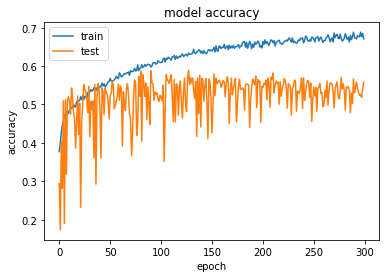

In [43]:
# Plotting the Train Valid Loss Graph

plt.plot(cnnhistory.history['categorical_accuracy'])
plt.plot(cnnhistory.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

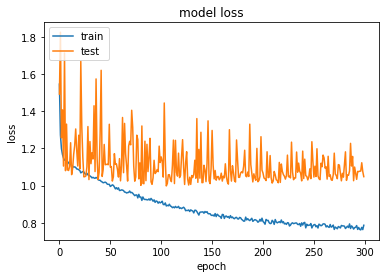

In [44]:
# Plotting the Train Valid Loss Graph

plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
#model = load_model('./gdrive/My Drive/develop/uni/deepl_project/runs/models/Audio_300_26_2DCNN_4L(64_32_32_32)_300.h5')

In [46]:

dataloader_dev = KerasDataloader('./gdrive/My Drive/develop/uni/deepl_project/data/','dev.json', config['padding_size'], False)
(x_dev, y_train), (x_val, y_val) = dataloader_dev.load_data()
x_dev = x_dev.reshape((x_dev.shape[0], x_dev.shape[1], x_dev.shape[2], 1))

predictions = model.predict(x_dev)
print(predictions.shape)


(3342, 4)


In [0]:
dataloader_dev.save_predictions(predictions)